# Neural networks in utilities

We begin by performing the necessary imports:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.insert(0, "/home/rodr/code/amortized-mxl-dev/release") 

import logging
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Fix random seed for reproducibility
np.random.seed(42)

## Generate simulated data

We predefine the fixed effects parameters (true_alpha) and random effects parameters (true_beta), as well as the covariance matrix (true_Omega), and sample simulated choice data for 500 respondents (num_resp), each with 5 choice situations (num_menus). The number of choice alternatives is set to 5. 

In [2]:
from core.dcm_fakedata import generate_fake_data_wide

num_resp = 500
num_menus = 5
num_alternatives = 5

true_alpha = np.array([-0.8, 0.8, 1.2])
true_beta = np.array([-0.8, 0.8, 1.0, -0.8, 1.5])
# dynamic version of generating Omega
corr = 0.8
scale_factor = 1.0
true_Omega = corr*np.ones((len(true_beta),len(true_beta))) # off-diagonal values of cov matrix
true_Omega[np.arange(len(true_beta)), np.arange(len(true_beta))] = 1.0 # diagonal values of cov matrix
true_Omega *= scale_factor

df = generate_fake_data_wide(num_resp, num_menus, num_alternatives, true_alpha, true_beta, true_Omega)
df.head()

Generating fake data...
Error: 45.16


,ALT1_XF1,ALT1_XF2,ALT1_XF3,ALT1_XR1,ALT1_XR2,ALT1_XR3,ALT1_XR4,ALT1_XR5,ALT2_XF1,ALT2_XF2,...,ALT5_XR1,ALT5_XR2,ALT5_XR3,ALT5_XR4,ALT5_XR5,choice,indID,menuID,obsID,ones
0,0.374540,0.950714,0.731994,0.502929,0.474680,0.301972,0.539872,0.248391,0.598658,0.156019,...,0.237133,0.323644,0.292095,0.797652,0.171230,2,0,0,0,1
1,0.183405,0.304242,0.524756,0.608472,0.051355,0.549528,0.063914,0.175877,0.431945,0.291229,...,0.981368,0.299731,0.278902,0.973245,0.728234,2,0,1,1,1
2,0.607545,0.170524,0.065052,0.585298,0.699323,0.709927,0.763336,0.067189,0.948886,0.965632,...,0.839992,0.718722,0.500256,0.273207,0.877216,3,0,2,2,1
3,0.662522,0.311711,0.520068,0.776655,0.837907,0.140789,0.314813,0.424885,0.546710,0.184854,...,0.296403,0.507946,0.230841,0.514504,0.683332,3,0,3,3,1
4,0.388677,0.271349,0.828738,0.085521,0.870117,0.593746,0.989603,0.025592,0.356753,0.280935,...,0.584885,0.684462,0.256079,0.832849,0.449690,0,0,4,4,1


## Mixed Logit specification with Neural Nets in utilities

We now make use of the developed formula interface to specify the utilities of the mixed logit model. 

We begin by defining the fixed effects parameters, the random effects parameters, and the observed variables. This creates instances of Python objects that can be put together to define the utility functions for the different alternatives.

For this model extension, we will also have to define the Neural Network that we will be using in the utilities. To simplify the usage, we have added support for Neural Networks to the formula interface. We can define a fully-connected neural network using:

```python
NNet = NeuralNetwork('NNet')
```

We can now use this ``NNet`` as a function in the utilities' specification:

```python
V1 = NNet('ALT1', ALT1_XF1, ALT1_XF2, ALT1_XF3) + B_XF1*ALT1_XF1 + B_XF2*ALT1_XF2 + B_XF3*ALT1_XF3 + B_XR1*ALT1_XR1 + B_XR2*ALT1_XR2 + B_XR3*ALT1_XR3 + B_XR4*ALT1_XR4 + B_XR5*ALT1_XR5
```

In this particular case, we are replacing the linear relationship 

Once the utilities are defined, we collect them in a Python dictionary mapping alternative names to their corresponding expressions.

In [3]:
from core.dcm_interface import FixedEffect, RandomEffect, ObservedVariable, NeuralNetwork
import torch.distributions as dists

# define observed variables
for attr in df.columns:
    exec("%s = ObservedVariable('%s')" % (attr,attr))

# define fixed effects parameters
B_XF1 = FixedEffect('BETA_XF1')
B_XF2 = FixedEffect('BETA_XF2')
B_XF3 = FixedEffect('BETA_XF3')

# define random effects parameters
B_XR1 = RandomEffect('BETA_XR1')
B_XR2 = RandomEffect('BETA_XR2')
B_XR3 = RandomEffect('BETA_XR3')
B_XR4 = RandomEffect('BETA_XR4')
B_XR5 = RandomEffect('BETA_XR5')

NNet = NeuralNetwork('NNet')

# define utility functions
V1 = NNet('ALT1', ALT1_XF1, ALT1_XF2, ALT1_XF3) + B_XF1*ALT1_XF1 + B_XF2*ALT1_XF2 + B_XF3*ALT1_XF3 + B_XR1*ALT1_XR1 + B_XR2*ALT1_XR2 + B_XR3*ALT1_XR3 + B_XR4*ALT1_XR4 + B_XR5*ALT1_XR5
V2 = NNet('ALT2', ALT2_XF1, ALT2_XF2, ALT2_XF3) + B_XF1*ALT2_XF1 + B_XF2*ALT2_XF2 + B_XF3*ALT2_XF3 + B_XR1*ALT2_XR1 + B_XR2*ALT2_XR2 + B_XR3*ALT2_XR3 + B_XR4*ALT2_XR4 + B_XR5*ALT2_XR5
V3 = NNet('ALT3', ALT3_XF1, ALT3_XF2, ALT3_XF3) + B_XF1*ALT3_XF1 + B_XF2*ALT3_XF2 + B_XF3*ALT3_XF3 + B_XR1*ALT3_XR1 + B_XR2*ALT3_XR2 + B_XR3*ALT3_XR3 + B_XR4*ALT3_XR4 + B_XR5*ALT3_XR5
V4 = NNet('ALT4', ALT4_XF1, ALT4_XF2, ALT4_XF3) + B_XF1*ALT4_XF1 + B_XF2*ALT4_XF2 + B_XF3*ALT4_XF3 + B_XR1*ALT4_XR1 + B_XR2*ALT4_XR2 + B_XR3*ALT4_XR3 + B_XR4*ALT4_XR4 + B_XR5*ALT4_XR5
V5 = NNet('ALT5', ALT5_XF1, ALT5_XF2, ALT5_XF3) + B_XF1*ALT5_XF1 + B_XF2*ALT5_XF2 + B_XF3*ALT5_XF3 + B_XR1*ALT5_XR1 + B_XR2*ALT5_XR2 + B_XR3*ALT5_XR3 + B_XR4*ALT5_XR4 + B_XR5*ALT5_XR5

# associate utility functions with the names of the alternatives
utilities = {"ALT1": V1, "ALT2": V2, "ALT3": V3, "ALT4": V4, "ALT5": V5}

We are now ready to create a Specification object containing the utilities that we have just defined. Note that we must also specify the type of choice model to be used - a mixed logit model (MXL) in this case.

Note that we can inspect the specification by printing the dcm_spec object.

In [4]:
from core.dcm_interface import Specification

# create MXL specification object based on the utilities previously defined
dcm_spec = Specification('MXL', utilities)
print(dcm_spec)

----------------- MXL specification:
Alternatives: ['ALT1', 'ALT2', 'ALT3', 'ALT4', 'ALT5']
Utility functions:
   V_ALT1 =  + BETA_XF1*ALT1_XF1 + BETA_XF2*ALT1_XF2 + BETA_XF3*ALT1_XF3 + BETA_XR1_n*ALT1_XR1 + BETA_XR2_n*ALT1_XR2 + BETA_XR3_n*ALT1_XR3 + BETA_XR4_n*ALT1_XR4 + BETA_XR5_n*ALT1_XR5
   V_ALT2 =  + BETA_XF1*ALT2_XF1 + BETA_XF2*ALT2_XF2 + BETA_XF3*ALT2_XF3 + BETA_XR1_n*ALT2_XR1 + BETA_XR2_n*ALT2_XR2 + BETA_XR3_n*ALT2_XR3 + BETA_XR4_n*ALT2_XR4 + BETA_XR5_n*ALT2_XR5
   V_ALT3 =  + BETA_XF1*ALT3_XF1 + BETA_XF2*ALT3_XF2 + BETA_XF3*ALT3_XF3 + BETA_XR1_n*ALT3_XR1 + BETA_XR2_n*ALT3_XR2 + BETA_XR3_n*ALT3_XR3 + BETA_XR4_n*ALT3_XR4 + BETA_XR5_n*ALT3_XR5
   V_ALT4 =  + BETA_XF1*ALT4_XF1 + BETA_XF2*ALT4_XF2 + BETA_XF3*ALT4_XF3 + BETA_XR1_n*ALT4_XR1 + BETA_XR2_n*ALT4_XR2 + BETA_XR3_n*ALT4_XR3 + BETA_XR4_n*ALT4_XR4 + BETA_XR5_n*ALT4_XR5
   V_ALT5 =  + BETA_XF1*ALT5_XF1 + BETA_XF2*ALT5_XF2 + BETA_XF3*ALT5_XF3 + BETA_XR1_n*ALT5_XR1 + BETA_XR2_n*ALT5_XR2 + BETA_XR3_n*ALT5_XR3 + BETA_XR4_n*ALT5_

Once the Specification is defined, we need to define the DCM Dataset object that goes along with it. For this, we instantiate the Dataset class with the Pandas dataframe containing the data in the so-called "wide format", the name of column in the dataframe containing the observed choices and the dcm_spec that we have previously created.

Note that since this is panel data, we must also specify the name of the column in the dataframe that contains the ID of the respondent (this should be a integer ranging from 0 the num_resp-1).

In [5]:
from core.dcm_interface import Dataset

# create DCM dataset object
dcm_dataset = Dataset(df, 'choice', dcm_spec, resp_id_col='indID')

Preparing dataset...
	Model type: MXL
	Num. observations: 2500
	Num. alternatives: 5
	Num. respondents: 500
	Num. menus: 5
	Observations IDs: [   0    1    2 ... 2497 2498 2499]
	Alternative IDs: None
	Respondent IDs: [  0   0   0 ... 499 499 499]
	Availability columns: None
	Attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT1_XR1', 'ALT1_XR2', 'ALT1_XR3', 'ALT1_XR4', 'ALT1_XR5', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT2_XR1', 'ALT2_XR2', 'ALT2_XR3', 'ALT2_XR4', 'ALT2_XR5', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT3_XR1', 'ALT3_XR2', 'ALT3_XR3', 'ALT3_XR4', 'ALT3_XR5', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT4_XR1', 'ALT4_XR2', 'ALT4_XR3', 'ALT4_XR4', 'ALT4_XR5', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3', 'ALT5_XR1', 'ALT5_XR2', 'ALT5_XR3', 'ALT5_XR4', 'ALT5_XR5']
	Fixed effects attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3']
	Fixed effec

As with the specification, we can inspect the DCM dataset by printing the dcm_dataset object:

In [6]:
print(dcm_dataset)

----------------- DCM dataset:
Model type: MXL
Num. observations: 2500
Num. alternatives: 5
Num. respondents: 500
Num. menus: 5
Num. fixed effects: 15
Num. random effects: 25
Attribute names: ['ALT1_XF1', 'ALT1_XF2', 'ALT1_XF3', 'ALT1_XR1', 'ALT1_XR2', 'ALT1_XR3', 'ALT1_XR4', 'ALT1_XR5', 'ALT2_XF1', 'ALT2_XF2', 'ALT2_XF3', 'ALT2_XR1', 'ALT2_XR2', 'ALT2_XR3', 'ALT2_XR4', 'ALT2_XR5', 'ALT3_XF1', 'ALT3_XF2', 'ALT3_XF3', 'ALT3_XR1', 'ALT3_XR2', 'ALT3_XR3', 'ALT3_XR4', 'ALT3_XR5', 'ALT4_XF1', 'ALT4_XF2', 'ALT4_XF3', 'ALT4_XR1', 'ALT4_XR2', 'ALT4_XR3', 'ALT4_XR4', 'ALT4_XR5', 'ALT5_XF1', 'ALT5_XF2', 'ALT5_XF3', 'ALT5_XR1', 'ALT5_XR2', 'ALT5_XR3', 'ALT5_XR4', 'ALT5_XR5']


## Bayesian Mixed Logit Model with Neural Networks in the utility functions in PyTorch

In the original implementation of the core MXL model, we considered utility function of the form:

$\require{color}$
$$
V_j = \boldsymbol\alpha^T \textbf{x}_{ntj,F} + \boldsymbol\beta_n^T \textbf{x}_{ntj,R}, 
$$

where $\textbf{x}_{ntj,F}^T$ and $\textbf{x}_{ntj,R}^T)$ are used to distinguish between covariates that pertain to the fixed parameters $\boldsymbol\alpha$ and random parameters $\boldsymbol\beta_n$, respectively.

We will now extend this to support utilties of the form:

$$
V_j = \boldsymbol\alpha^T \textbf{x}_{ntj,F} + \boldsymbol\beta_n^T \textbf{x}_{ntj,R} \color{red} + f_{\boldsymbol\theta}(\textbf{x}_{ntj,E}), 
$$

where $f_{\boldsymbol\theta}$ is a neural network with parameters $\boldsymbol\theta$, and $\textbf{x}_{ntj,E}$ is a set of additional covariates describing either the alternative $j$ or the socio-demographic characteristics of the individual $n$ (or both!). 

In our implementation, we will NOT consider a prior over $\boldsymbol\theta$ and perform Bayesian inference on its values. Instead, we find point estimates for $\boldsymbol\theta$ using a Type-II Maximum Likelihood approach (also commonly refered to as "Empirical Bayes"). We can obtain Maximum Likelihood estimates of $\boldsymbol\theta$ by directly maximizing the ELBO w.r.t. $\boldsymbol\theta$ using stochastic gradient descent. As a consequence, the generative process of this model extension remains similar to the core MXL model:

1. Draw fixed taste parameters $\boldsymbol\alpha \sim \mathcal{N}(\boldsymbol\lambda_0, \boldsymbol\Xi_0)$
2. Draw mean vector $\boldsymbol\zeta \sim \mathcal{N}(\boldsymbol\mu_0, \boldsymbol\Sigma_0)$
3. Draw scales vector $\boldsymbol\theta \sim \mbox{half-Cauchy}(\boldsymbol\sigma_0)$
4. Draw correlation matrix $\boldsymbol\Psi \sim \mbox{LKJ}(\nu)$
5. For each decision-maker $n \in \{1,\dots,N\}$
    1. Draw random taste parameters $\boldsymbol\beta_n \sim \mathcal{N}(\boldsymbol\zeta,\boldsymbol\Omega)$
    2. For each choice occasion $t \in \{1,\dots,T_n\}$
        1. Draw observed choice $y_{nt} \sim \mbox{MNL}(\boldsymbol\alpha, \boldsymbol\beta_n, \textbf{X}_{nt})$
        

This model is already implemented in the class ``TorchMXL_NNET``. At the end of this notebook, we provide an explanation of how this extension was implemented. 

We can instantiate this model from the ``TorchMXL_NNET`` using the following code. We can the run variational inference to approximate the posterior distribution of the latent variables in the model. Note that since in this case we know the true parameters that were used to generate the simualated choice data, we can pass them to the "infer" method in order to obtain additional information during the ELBO maximization (useful for tracking the progress of VI and for other debugging purposes). 

[Epoch     0] ELBO: 7568; Loglik: -5277; Acc.: 0.204; Alpha RMSE: 0.948; Beta RMSE: 1.021
[Epoch   100] ELBO: 7061; Loglik: -4578; Acc.: 0.249; Alpha RMSE: 0.576; Beta RMSE: 0.989
[Epoch   200] ELBO: 4771; Loglik: -3839; Acc.: 0.344; Alpha RMSE: 0.337; Beta RMSE: 0.935
[Epoch   300] ELBO: 5019; Loglik: -3809; Acc.: 0.370; Alpha RMSE: 0.172; Beta RMSE: 0.879
[Epoch   400] ELBO: 4385; Loglik: -3525; Acc.: 0.418; Alpha RMSE: 0.138; Beta RMSE: 0.803
[Epoch   500] ELBO: 4144; Loglik: -3506; Acc.: 0.433; Alpha RMSE: 0.098; Beta RMSE: 0.707
[Epoch   600] ELBO: 4223; Loglik: -3455; Acc.: 0.432; Alpha RMSE: 0.087; Beta RMSE: 0.621
[Epoch   700] ELBO: 4156; Loglik: -3334; Acc.: 0.444; Alpha RMSE: 0.102; Beta RMSE: 0.536
[Epoch   800] ELBO: 4289; Loglik: -3352; Acc.: 0.448; Alpha RMSE: 0.112; Beta RMSE: 0.439
[Epoch   900] ELBO: 4072; Loglik: -3278; Acc.: 0.477; Alpha RMSE: 0.106; Beta RMSE: 0.364
[Epoch  1000] ELBO: 3990; Loglik: -3275; Acc.: 0.466; Alpha RMSE: 0.120; Beta RMSE: 0.286
[Epoch  11

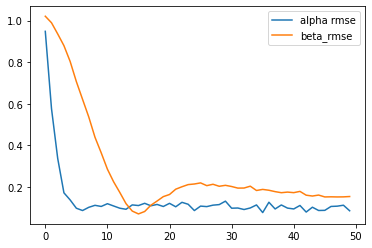

CPU times: user 12min 35s, sys: 1.63 s, total: 12min 37s
Wall time: 1min 5s


In [7]:
%%time

from core.torch_mxl_nnet import TorchMXL_NNET

# instantiate MXL model
mxl = TorchMXL_NNET(dcm_dataset, batch_size=num_resp, use_inference_net=False, use_cuda=True)

# run Bayesian inference (variational inference)
results = mxl.infer(num_epochs=5000, true_alpha=true_alpha, true_beta=true_beta)

The "results" dictionary containts a summary of the results of variational inference, including means of the posterior approximations for the different parameters in the model:

In [9]:
results

{'Estimation time': 62.10113286972046,
 'Est. alpha': array([-0.8451671 ,  0.63595444,  1.2062775 ], dtype=float32),
 'Est. zeta': array([-0.95948696,  0.99335897,  1.1875029 , -0.8028934 ,  1.4382907 ],
       dtype=float32),
 'Est. beta_n': array([[-0.49697894,  2.2429886 ,  2.1291854 ,  0.65689504,  2.1173    ],
        [-0.07704893,  2.2993453 ,  1.9180169 , -0.26712865,  2.3546276 ],
        [-0.5905319 ,  1.7121023 ,  1.1440365 , -0.00486669,  2.5219452 ],
        ...,
        [-0.90295714,  0.6258056 ,  1.360058  , -1.3241246 ,  1.7442591 ],
        [-0.4988995 ,  1.2671847 ,  1.4033059 , -1.0043036 ,  1.5476954 ],
        [-0.86154854,  1.2394235 ,  0.8732216 , -1.0529066 ,  1.8300217 ]],
       dtype=float32),
 'ELBO': 3805.753173828125,
 'Loglikelihood': -3375.33447265625,
 'Accuracy': 0.43799999356269836}

This interface is currently being improved to include additional output information, but additional information can be obtained from the attributes of the "mxl" object for now. 

## Implementation details

TODO